# Introduction to AG2

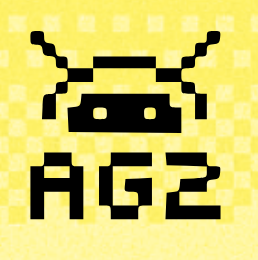

The best way to go about exploring AG2 (or any framework for that matter) is by building something. Let's build something to accelerate our AI research.

As a researcher, first we decide on a topic that we are interested in exploring and then gauge the current state-of-the-art. To do this, we need to be up-to-date with the latest papers in that area/topic. Once we get an idea on what's happening in the field, we can zero-in on most relevant & interesting papers and go throught them in detail. Once we do that, we can understand and reason the current limitations and potentially address those limitations or comeup with new ideas based on reading them.

Let's see how AG2 can help in this regard.

In [ ]:
# Installing AG2 and other dependencies
!pip install "ag2[openai, captainagent, browser-use, crawl4ai, rag]"
!playwright install
!playwright install-deps
!pip install nest_asyncio

In [ ]:
import os
from autogen import LLMConfig

In [ ]:
# LLM Configuration

llm_config = LLMConfig(
  api_type="openai",
  model="gpt-4o-mini",
  api_key=os.environ["OPENAI_API_KEY"],
)

# Few Concepts

**[ConversableAgent](https://docs.ag2.ai/docs/user-guide/basic-concepts/conversable-agent)**:

Simplest fully functional agent at the heart of all AG2 agents



```
# 1. Import our agent class
from autogen import ConversableAgent, LLMConfig

# 2. Create our agent
with llm_config:
    my_agent = ConversableAgent(
        name="helpful_agent",
        system_message="You are a research assistant, explain the concepts clearly.",
    )

# 3. Chat directly with our agent
my_agent.run("What is reasoning in LLM and how is it accomplished?")
```
---

### How to orchestrate agents?

**[Sequential chat](https://docs.ag2.ai/docs/user-guide/basic-concepts/orchestration/sequential-chat)**:

A sequence of chats between two agents chained together by a mechanism called carryover, the sequential chat pattern is useful for complex tasks that can be broken down into interdependent sub-tasks.


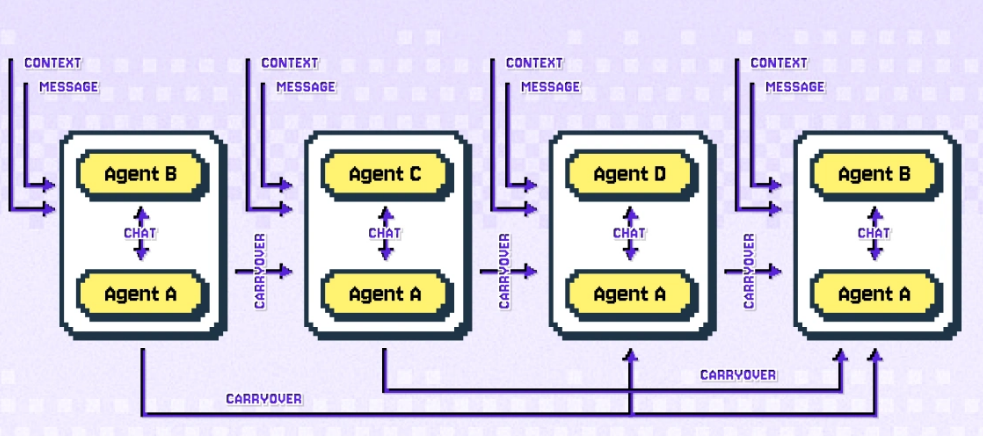

[Swarms](https://docs.ag2.ai/docs/user-guide/basic-concepts/orchestration/swarm):

Swarms are a versatile pattern that provide flows between agents that are determined at the swarm or agent-level. The control of the flow is managed through various mechanisms, including hand-offs, post-tool transitions, post-work transitions, or an internal group chat manager, all of which determine the next agent (or end the swarm).

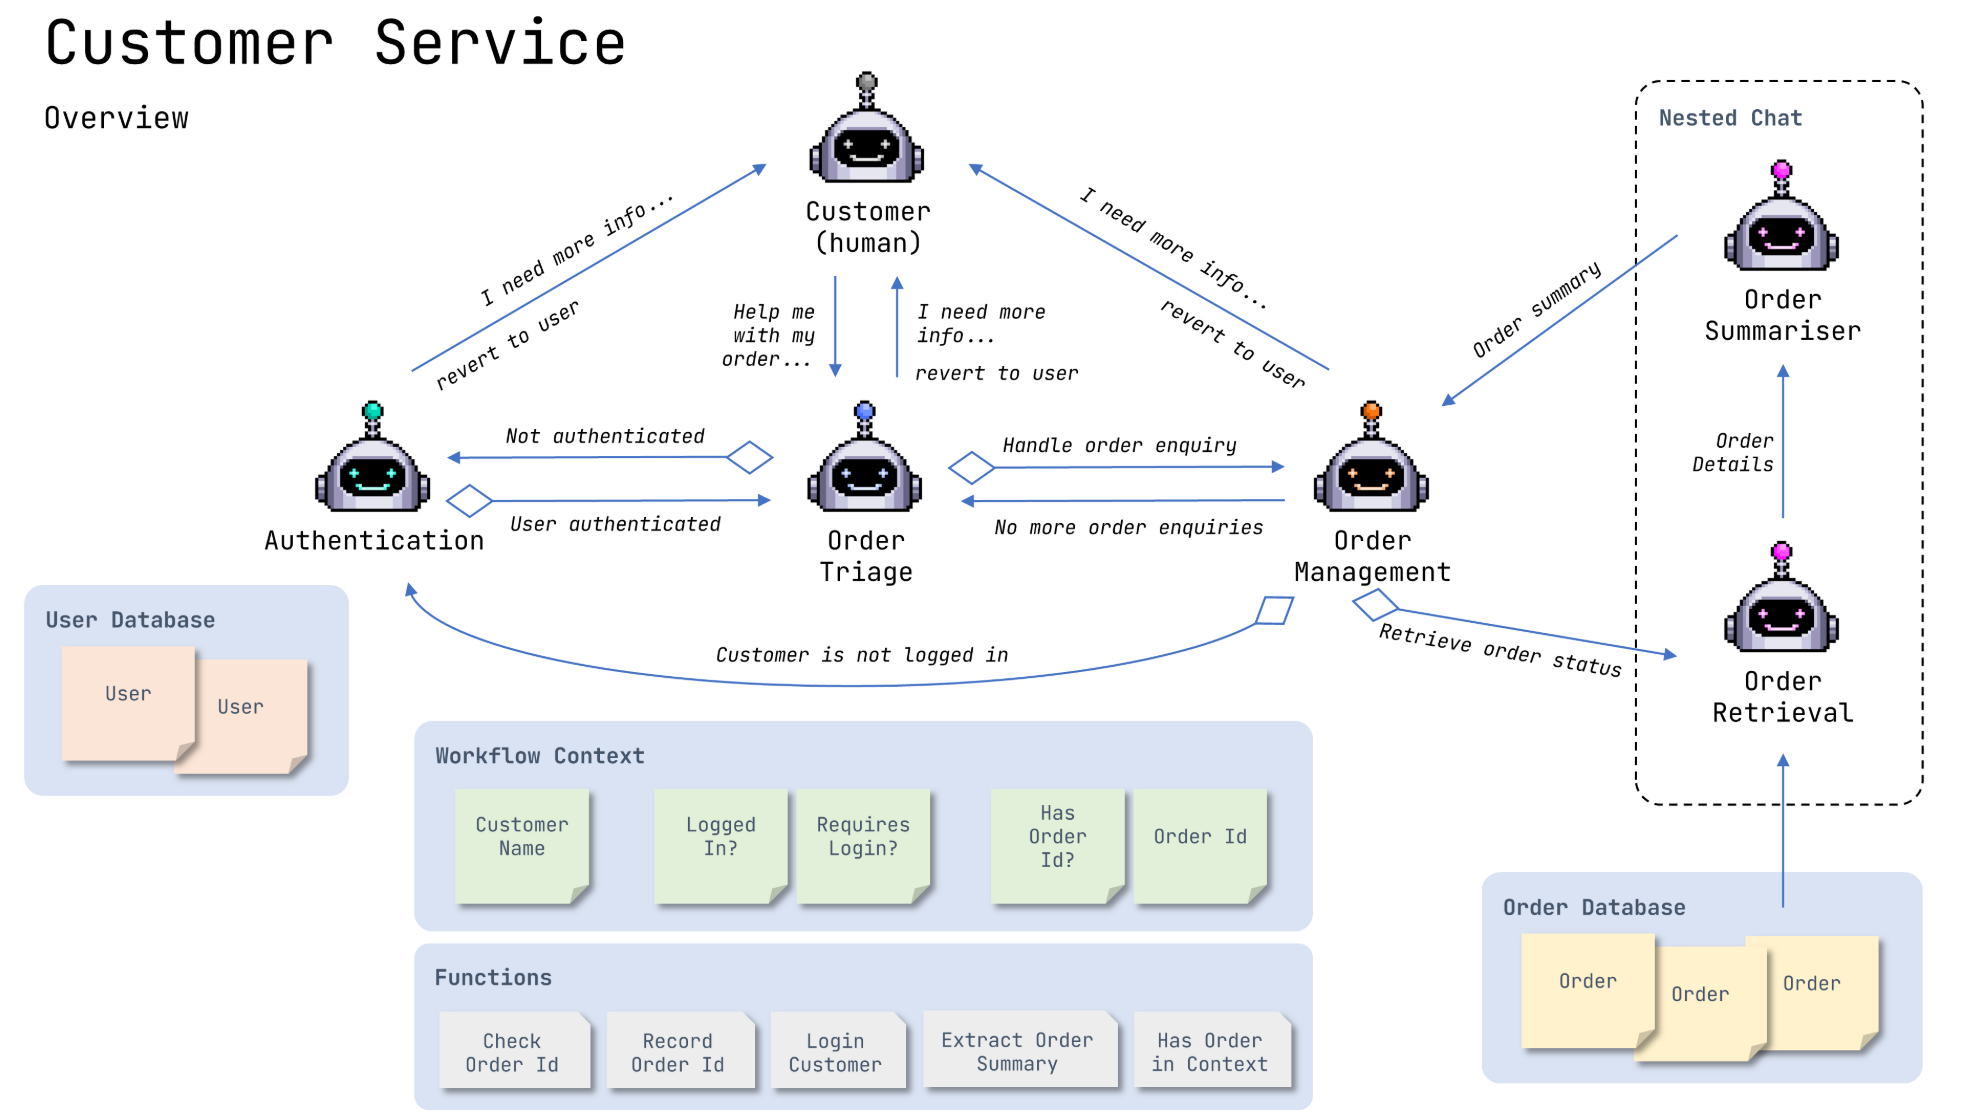



---



---



Now, let's delineate the steps involved in doing research-


1. Browse through Arxiv or other similar repositories
2. Find the most relevant papers and rank them
3. Skim through the abstracts/summaries for all the papers
4. Shortlist interesting and relevant papers
5. Understand the shortlisted papers in detail
6. Identify areas of improvement or come-up with novel ideas



# [WebSurferAgent](https://docs.ag2.ai/docs/user-guide/reference-agents/websurferagent)

An agent that can browse, extract, or interact with the web

In [ ]:
# 1. Import our WebSurferAgent
from autogen.agents.experimental import WebSurferAgent


# 2. Add additional browser configurations for our browser-use tool
browser_use_browser_config = {"browser_config": {"headless": False}, "agent_kwargs": {"generate_gif": True}}

# 3. Create the agent, nominating the tool and tool config
with llm_config:
    web_researcher = WebSurferAgent(
        name="researcher",
        web_tool="browser_use",
        web_tool_kwargs=browser_use_browser_config,
    )

# 4. Run our agent, passing in the tools that our WebSurferAgent has so they can be executed
ag2_news_result = web_researcher.run(
    "Search for the latest papers on the topic of 'Reasoning in Large Language Models (LLMs)' on 'https://arxiv.org/'" + \
    "Return the urls of top 3 most recent and most cited papers. Also, provide detailed summarries for each of the papers",
    tools=web_researcher.tools,
)

print(ag2_news_result.summary)

In [ ]:
papers_urls = ["https://arxiv.org/pdf/2503.16401",
                "https://arxiv.org/pdf/2503.16419",
                "https://arxiv.org/pdf/2503.16385"]

# [DocAgent](https://docs.ag2.ai/docs/user-guide/reference-agents/docagent)

Handles document ingestion and query tasks seamlessly, and with natural language instructions, by leveraging an internal swarm of agents to streamline document processing and information retrieval.
Internally, DocAgent orchestrates the following swarm agents:


1. Triage Agent: Decides what type of task to perform from user requests.
2. Task Manager Agent: Manages the tasks and initiates actions.
3. Data Ingestion Agent: Ingests the documents.
4. Query Agent: Answers user questions based on ingested documents.
5. Error Agent: If anything fails, the error agent will report the problem back.
6. Summary Agent: Generates a summary of the completed tasks.


In [ ]:
from autogen.agents.experimental import DocAgent


# Create our DocAgent
with llm_config:
    document_agent = DocAgent()

# Run the DocAgent to extract details from specific interesting papers
document_agent.run(
    f"Extract the problem statement, motivation, detailed methodology and conclusion and future work from the paper {papers_urls[2]} (if present) and provide detailed explanations", # Describe the methodology and novelty of the paper {papers_urls[0]} and provide detailed explanations on the results and findings",
    max_turns=2
)

# [ReasoningAgent](https://docs.ag2.ai/docs/user-guide/reference-agents/reasoningagent)

Designed to enhance language models' reasoning capabilities through systematic exploration of thought processes. By implementing the Tree of Thoughts (ToT) framework, it enables LLMs to break down complex problems into manageable steps and explore multiple solution paths simultaneously.

**Core Components**



1. Thinker Agent: Generates potential next steps in the reasoning process
2. Grader Agent: Evaluates the quality of each reasoning step
3. Interim Execution: Option to execute the selected steps, enabling stepwise reasoning.
4. Code Execution: a child user agent will execute code automatically during reasoning
5. Tree Structure: Organizes thoughts hierarchically for systematic exploration
6. Visualization Tools: Built-in Graphviz support for analyzing reasoning paths
7. Logging Features: Log and save thinking trajectories to finetune the language model
8. Configuration Options: The agent is highly configurable through a single reason_config dictionary



In [ ]:
paper_summary = "The paper presents a framework for optimizing Long Chain-of-Thought (CoT) data, focusing on enhancing the efficiency of structured reasoning processes. It introduces a systematic approach called DLCoT, which involves five key steps: Macro-Structure Parsing, Approach & Verification Parsing, Redundancy Analysis, Optimized Integration, and Coherence Reconstruction. These steps aim to deconstruct reasoning chains, identify critical components, and improve data distillation by eliminating redundancies and ensuring logical consistency.\n\nThe experimental setup includes datasets from NuminaMath and Bespoke-Stratos, with answers generated using specific large language models. The experiments utilize models from the Qwen and Llama series, employing a consistent training methodology to ensure fairness and reliability. The paper emphasizes the importance of verification and summary in computational processes, highlighting a structured approach to problem-solving."

In [ ]:
import random

from autogen.agents.experimental import ReasoningAgent, ThinkNode
from autogen import AssistantAgent, UserProxyAgent, LLMConfig

verbose = True

question = f"Based on the paper summary -]{paper_summary}', generate new ideas for improving the 'DLCoT framework' and suggest potential areas for future research."
random.seed(1)  # setup seed for reproducibility

def last_meaningful_msg(sender, recipient, summary_args):
    import warnings

    if sender == recipient:
        return "TERMINATE"

    summary = ""
    chat_messages = recipient.chat_messages[sender]

    for msg in reversed(chat_messages):
        try:
            content = msg["content"]
            if isinstance(content, str):
                summary = content.replace("TERMINATE", "")
            elif isinstance(content, list):
                # Remove the `TERMINATE` word in the content list.
                summary = "\n".join(
                    x["text"].replace("TERMINATE", "") for x in content if isinstance(x, dict) and "text" in x
                )
            if summary.strip().rstrip():
                return summary
        except (IndexError, AttributeError) as e:
            warnings.warn(f"Cannot extract summary using last_msg: {e}. Using an empty str as summary.", UserWarning)
    return summary

In [ ]:
with llm_config:
   reason_agent = ReasoningAgent(
      name="reason_agent",
      system_message="answer math questions",
      verbose=verbose,
      reason_config={"method": "dfs", "max_depth": 3},  # Using DFS
      # NOTE: it is equivalent to use beam size 1 for O1-style reasoning
      # reason_config={"method": "beam_search", "beam_size": 1, "max_depth": 3},
   )
user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False,
    max_consecutive_auto_reply=10,
)

reasoning_agent_result = user_proxy.initiate_chat(reason_agent, message=question, summary_method=last_meaningful_msg)

print(reasoning_agent_result.summary)




> SUMMARY: The discussion revolves around enhancing the DLCoT framework, which focuses on optimizing Long Chain-of-Thought (CoT) data for better structured reasoning. Proposed improvements include:

> 1. **Macro-Structure Parsing Enhancements:** Utilizing transformer models for better structure detection and developing contextual awareness algorithms that adjust dynamically.
2. **Approach & Verification Parsing Improvements:** Employing diverse verification techniques and creating a user-friendly interactive verification tool for real-time feedback.
3. **Advanced Optimized Integration:** Implementing data fusion methods like Bayesian networks and ensemble learning strategies to improve the robustness of reasoning outputs.
4. **Comprehensive Redundancy Analysis:** Developing algorithms for semantic redundancy detection and leveraging reinforcement learning to minimize redundancies.
5. **Coherence Reconstruction Enhancements:** Focusing on narrative flow optimization and user-centric personalization features.

> Future research suggestions include investigating ethical considerations in AI reasoning, exploring interdisciplinary applications of the DLCoT framework, and developing real-time adaptive systems.





---



### *End-to-end task accomplishment?*



---



# [DeepResearchAgent](https://docs.ag2.ai/docs/user-guide/reference-agents/deepresearchagent)

A powerful autonomous research capability within the AG2 framework. Inspired by OpenAI’s Deep Research, DeepResearchAgent is designed to tackle complex, multi-step research tasks efficiently, synthesizing insights from diverse online sources.[link text](https://)

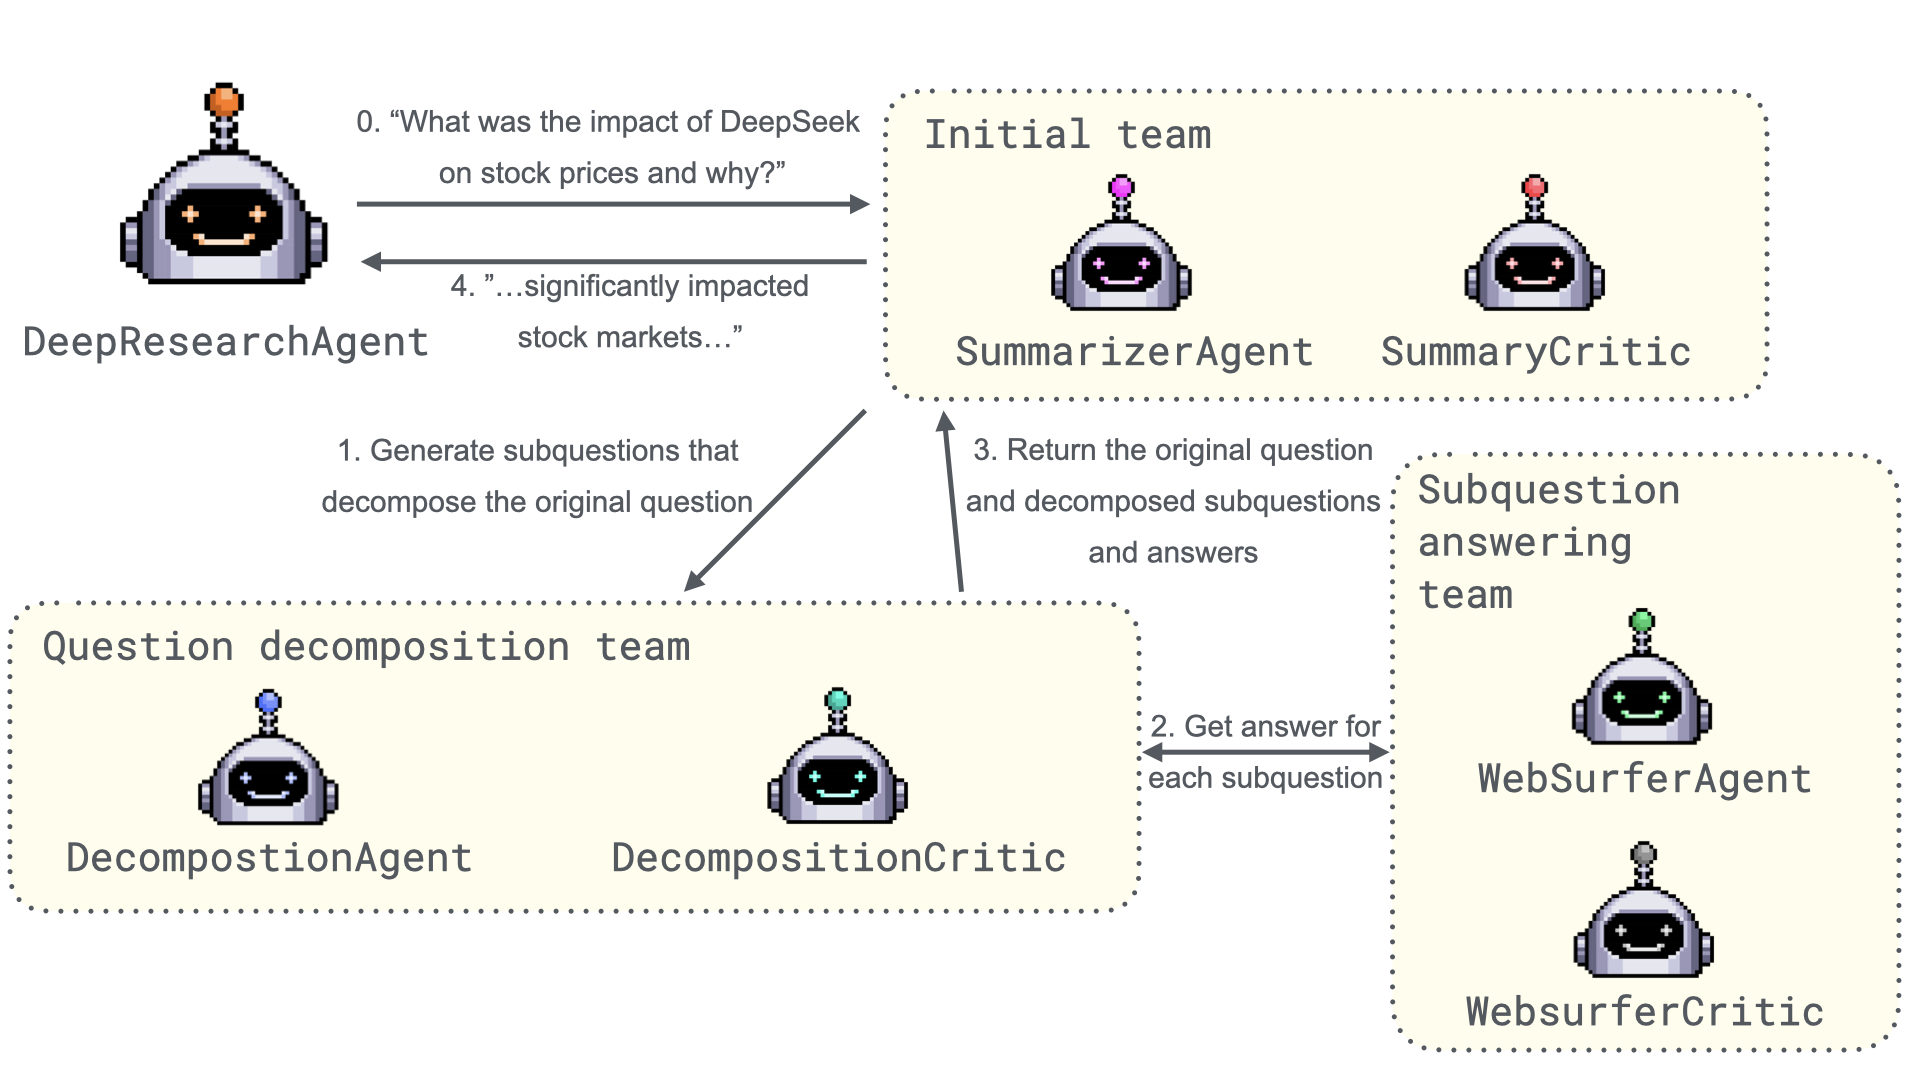

In [ ]:
# 1. Imports
import nest_asyncio
from autogen.agents.experimental import DeepResearchAgent
nest_asyncio.apply()

# 2. Create the agent, nominating the tool and tool config
with llm_config:
    agent = DeepResearchAgent(name="DeepResearchAgent")

# 3. Specify the task you want DeepResearchAgent to solve
message =  "Search for the latest papers on the topic of 'Reasoning in Large Language Models (LLMs)' on 'https://arxiv.org/'" + \
            "Return the urls of top 3 most recent and most cited papers. Also, provide detailed summarries for each of the papers" +\
            "Based on the summaries of the papers,  provide suggestions for improvement and generate new ideas"

deep_research_agent_result = agent.run(
    message=message,
    tools=agent.tools,
    max_turns=2,
    user_input=False,
    summary_method="reflection_with_llm",
)

print(deep_research_agent_result.summary)

# [CaptainAgent](https://docs.ag2.ai/docs/user-guide/reference-agents/captainagent)

An agent enhanced with the capability to call AutoBuild to break down and solve complex tasks.

AutoBuild can initiate a group chat between a group of experts and converse to solve the task. The experts in nested chat can be retrieved from agent library. The agents can be equipped with tools for advanced coding.

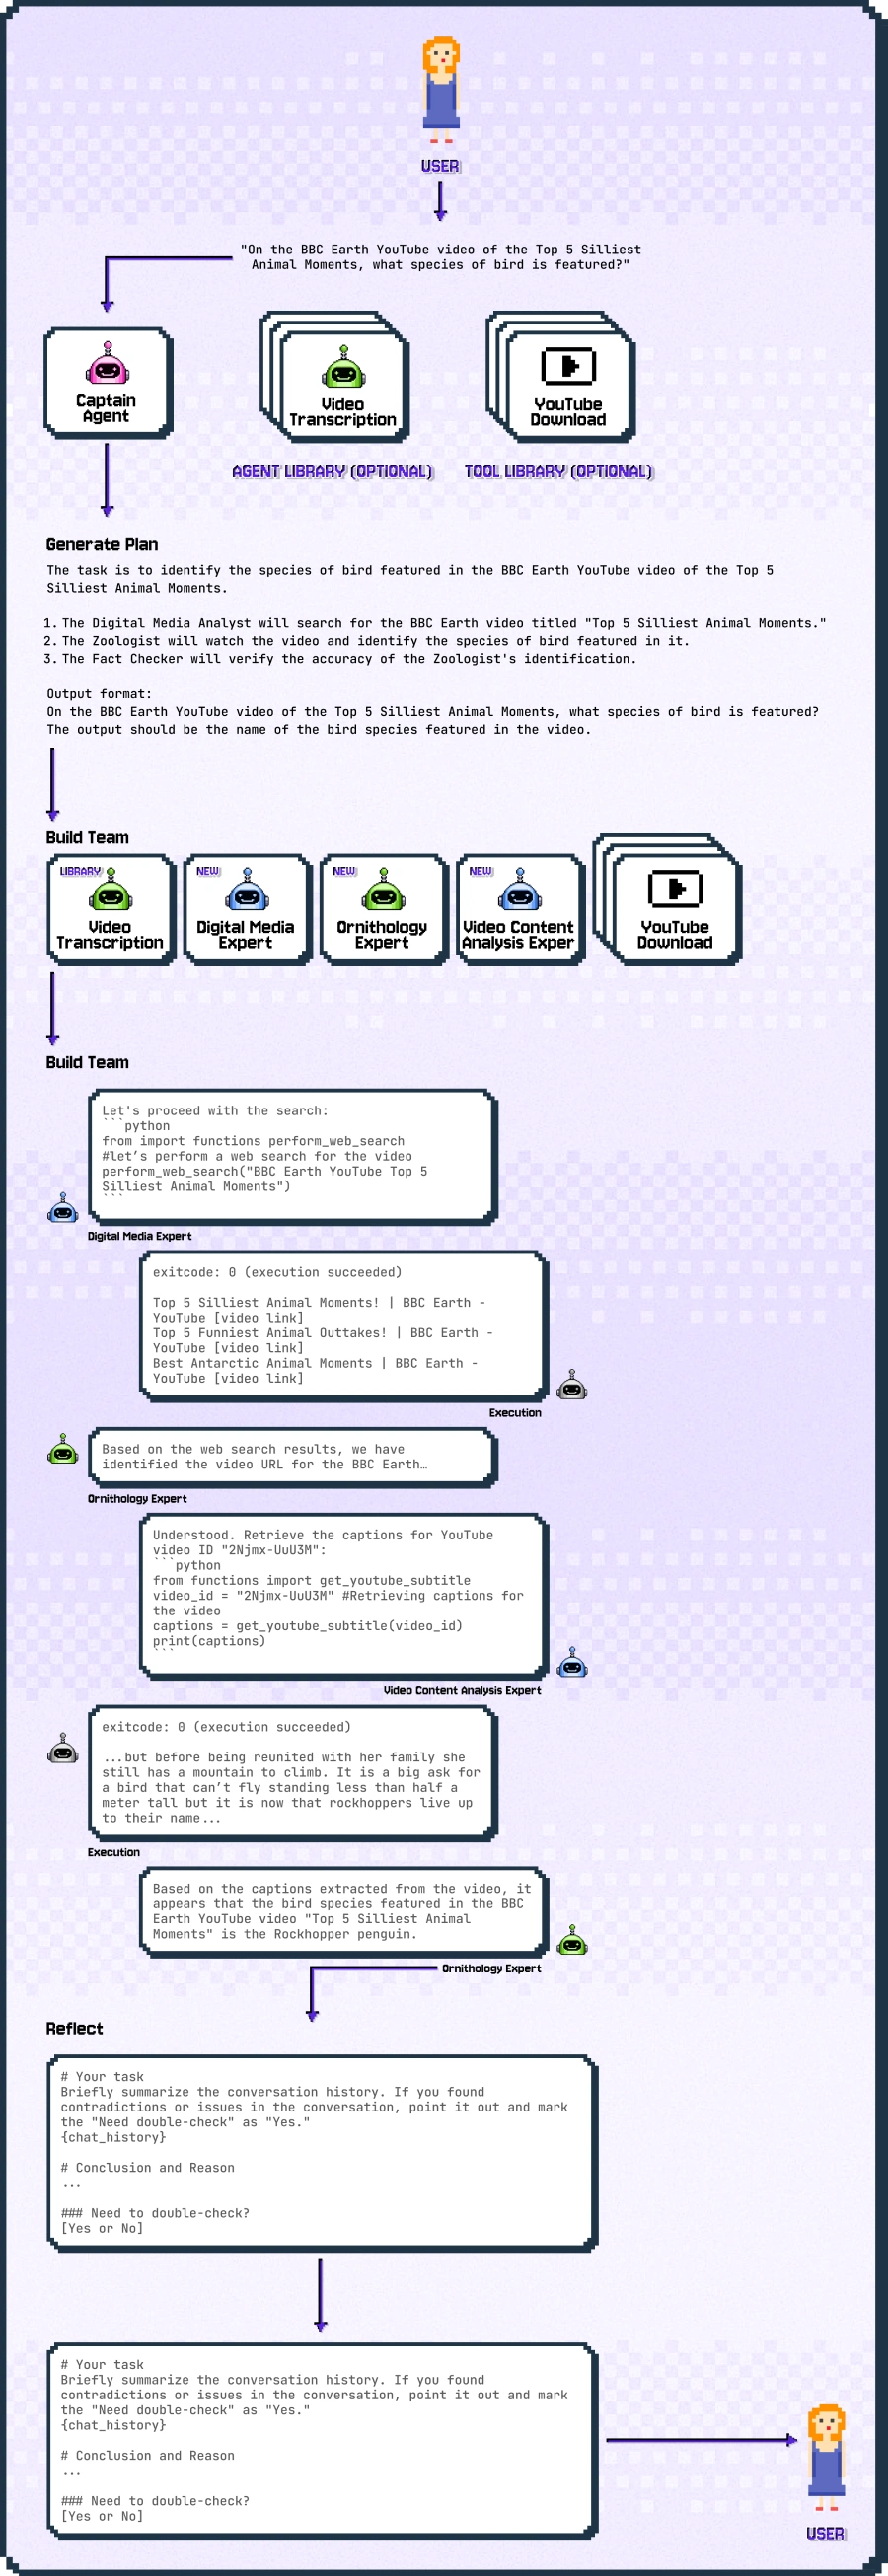

In [ ]:
# 1. Imports

from autogen import UserProxyAgent
from autogen.agentchat.contrib.captainagent import CaptainAgent

# 2. Create the agent, nominating the tool and tool config
with llm_config:
  captain_agent = CaptainAgent(
      name="captain_agent",
      code_execution_config={"use_docker": False, "work_dir": "groupchat"},
      agent_config_save_path=None,  # If you'd like to save the created agents in nested chat for further use, specify the save directory here
  )
captain_user_proxy = UserProxyAgent(name="captain_user_proxy", human_input_mode="NEVER")

# 3. Initaite the chat with CaptainAgent
captain_agent_result = captain_user_proxy.initiate_chat(
    captain_agent,
    message=message,
    max_turns=1,
    summay_method=last_meaningful_msg
)

print(captain_agent_result)